In [123]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [124]:
#standard imports
import time
import pymongo as pm
import numpy as np
import h5py
import scipy as sp
import scipy.stats as stats

#our own internal utility unctions
import metrics ; reload(metrics)
import cross_validation as cv; reload(cv)
import utils; reload(utils)
from utils import featurewise_norm
import minimum_distance_classifier as mdc

#and the relevant things from sklearn
from sklearn.svm import LinearSVC

In [125]:
#ok let's load the data 
DATA_PATH = "/home/chengxuz/Class/psych253_2018/data/ventral_neural_data.hdf5"
Ventral_Dataset = h5py.File(DATA_PATH)

categories = Ventral_Dataset['image_meta']['category'][:]   #array of category labels for all images  --> shape == (5760,)
unique_categories = np.unique(categories)                #array of unique category labels --> shape == (8,)
objects = Ventral_Dataset['image_meta']['object_name'][:]   #array of object labels for all images --> shape == (5670,)
unique_objects = np.unique(objects)                      #array of unique object labels --> shape == (64,) 

objects_by_category = {c: np.unique(objects[categories == c]) 
                       for c in unique_categories}

Neural_Data = Ventral_Dataset['time_averaged_trial_averaged'][:]
IT_NEURONS = Ventral_Dataset['neural_meta']['IT_NEURONS']
V4_NEURONS = Ventral_Dataset['neural_meta']['V4_NEURONS']
V4_Neural_Data = Neural_Data[:, V4_NEURONS]
IT_Neural_Data = Neural_Data[:, IT_NEURONS]

var_level = Ventral_Dataset['image_meta']['variation_level'][:]

#use numpy recarray object to store metadata 
meta_array = np.core.records.fromarrays(Ventral_Dataset['image_meta'].values(),
                                        names=Ventral_Dataset['image_meta'].keys())

## Nearest Neighbor classifiers

In [126]:
splits = cv.get_splits(meta_array, 
                        lambda x: x['object_name'],  
                        5,  
                        5,  
                        75,  
                        train_filter=lambda x: (x['variation_level'] in ['V3', 'V6']),
                        test_filter=lambda x: (x['variation_level'] in ['V3', 'V6'])
                       )

In [127]:
t0 = time.time()
SVM_res = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                 labels=meta_array['category'],
                                 splits=splits,
                                 model_class=LinearSVC,
                                 model_args={'C': 1e-3}
                                 )
t_SVM = time.time() - t0

In [128]:
t0 = time.time()
MDC_res = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                 labels=meta_array['category'],
                                 splits=splits,
                                 model_class=mdc.MinimumDistanceClassifier
                                 )
t_MDC = time.time() - t0

In [129]:
from sklearn.neighbors import KNeighborsClassifier

In [130]:
t0 = time.time()
KNN_res = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                 labels=meta_array['category'],
                                 splits=splits,
                                 model_class=KNeighborsClassifier,
                                 model_args={'n_neighbors': 5}
                                 )
t_KNN = time.time() - t0

In [131]:
print('SVM Accuracy: %.2f%%, Time: %fs' % (SVM_res[0]['test']['mean_accuracy']*100, t_SVM))
print('MDC Accuracy: %.2f%%, Time: %fs' % (MDC_res[0]['test']['mean_accuracy']*100, t_MDC))
print('KNN Accuracy: %.2f%%, Time: %fs' % (KNN_res[0]['test']['mean_accuracy']*100, t_KNN))
#chance here is an 12.5%

SVM Accuracy: 73.50%, Time: 3.400555s
MDC Accuracy: 52.81%, Time: 0.204277s
KNN Accuracy: 52.44%, Time: 60.671547s


## Logistic Regression

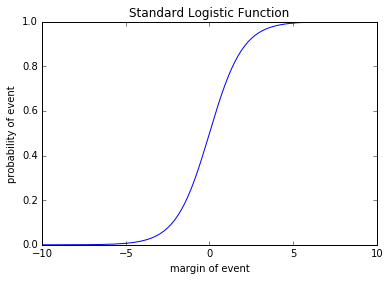

In [122]:
#Let's have a look at the output of the logistic function
def standard_logistic(x):
    return 1. / (1 + np.exp(-x))

x = np.arange(-10, 10, .1)
y = standard_logistic(x)
plt.plot(x, y)
plt.xlabel('margin of event')
plt.ylabel('probability of event')
plt.title('Standard Logistic Function')

In [27]:
from sklearn.linear_model import LogisticRegression

In [44]:
#this uses the one-vs-all strategy to handle multiclass logistic regression
t0 = time.time()
LR_res = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                 labels=meta_array['category'],
                                 splits=splits,
                                 model_class=LogisticRegression,
                                 model_args={'solver': 'saga',
                                            'C': 1e-2}
                                 )
t_LR = time.time() - t0

In [45]:
print('LR Accuracy: %.2f%%, Time: %fs' % (LR_res[0]['test']['mean_accuracy']*100, t_LR))


LR Accuracy: 73.75%, Time: 39.894243s


### Logistic Regression with Softmax multiclass

In [42]:
#this uses the softmax strategy to handle multiclass logistic regression
t0 = time.time()
LRmult_res = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                 labels=meta_array['category'],
                                 splits=splits,
                                 model_class=LogisticRegression,
                                 model_args={'solver': 'saga',
                                            'C': 1e-2, 
                                            'multi_class': 'multinomial'}
                                 )
t_LRmult = time.time() - t0

In [43]:
print('Multinomial LR Accuracy: %.2f%%, Time: %fs' % (LRmult_res[0]['test']['mean_accuracy']*100,
                                                      t_LRmult))


Multinomial LR Accuracy: 73.19%, Time: 24.043770s


In [97]:
#lets investigate a little more closely and actualyl look at one trained 
#logistic regression model
splits_1 = cv.get_splits(meta_array, 
                        lambda x: x['object_name'],  
                        1,  
                        5,  
                        75,  
                        train_filter=lambda x: (x['variation_level'] in ['V3', 'V6']),
                        test_filter=lambda x: (x['variation_level'] in ['V3', 'V6'])
                       )

LR_res_1 = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                 labels=meta_array['category'],
                                 splits=splits_1,
                                 model_class=LogisticRegression,
                                 model_args={'solver': 'saga',
                                             'multi_class': 'multinomial',
                                            'C': 1e-2},
                                 return_models=True
                                 )

model = LR_res_1[0]['models'][0]

model_weights = model.coef_
model_intercept = model.intercept_

In [119]:
test_data = Neural_Data[splits_1[0]['test']]
print('Number of test stimuli: %d' % test_data.shape[0])
#recall, we have to do feature norm since that was done in the training
fmean = LR_res_1[0]['training_sidedata'][0]['fmean']
fvar = LR_res_1[0]['training_sidedata'][0]['fvar']
normed_test_data = featurewise_norm(test_data, fmean=fmean, fvar = fvar)[0]

test_hyperplane = np.dot(normed_test_data, model.coef_.T) + model_intercept

test_margins = model.decision_function(normed_test_data)

test_probabilities = model.predict_proba(normed_test_data)

Number of test stimuli: 320


In [120]:
example_ind = 0
print(test_hyperplane[example_ind])
print(test_margins[example_ind])

#ok, so the decision function is outputting the same as for the SVM
#e.g. the output of "w * x + b", the distance of the point to the classifier hyperplane

[ 1.41985537 -3.235781   -2.71192701 -0.72023777  1.8538752   7.338307
 -2.99996659 -0.9441252 ]
[ 1.41985537 -3.235781   -2.71192701 -0.72023777  1.8538752   7.338307
 -2.99996659 -0.9441252 ]


In [121]:
#but what's the relationship between the decision function and the predicted probabilities?
def softmax(x):
    exp_vector = np.exp(x)
    exp_vector_sum = exp_vector.sum()
    return exp_vector / exp_vector_sum

example_ind = 0
print(softmax(test_margins[example_ind]))
print(test_probabilities[example_ind])

#ah, ok, so the probabilities are exactly the result of the softmax function applied
#to the classifier margins 
#of course, note that the estimated probability of the correct class 
#(in the case, the 5th class) is the highest -- > 99.2%

[  2.66931271e-03   2.53794539e-05   4.28537832e-05   3.14028318e-04
   4.11994934e-03   9.92545312e-01   3.21288489e-05   2.51035847e-04]
[  2.66931271e-03   2.53794539e-05   4.28537832e-05   3.14028318e-04
   4.11994934e-03   9.92545312e-01   3.21288489e-05   2.51035847e-04]
